In [1]:
%reload_ext autoreload
%autoreload 2
import torch
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import transforms
import torchvision
import copy
from exitai.learner import Learner
from exitai.const import LR_TRACKER

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(1)

In [3]:
class TempDataSet(Dataset):
    def __getitem__(self, index):
        return torch.tensor([1.,0.]), 1
    def __len__(self):
        return 3
temp_data_set = TempDataSet()
data_loader_train = DataLoader(temp_data_set, 2, shuffle=True, num_workers=8)
data_loader_test = DataLoader(temp_data_set, 2, shuffle=True, num_workers=8)

In [4]:
def model_loss_func(input_data, model, phase):
    input, target = input_data
    output = model(input)
    return output, F.cross_entropy(output, target)
    
model = nn.Linear(2, 2)

### 1. lr_find

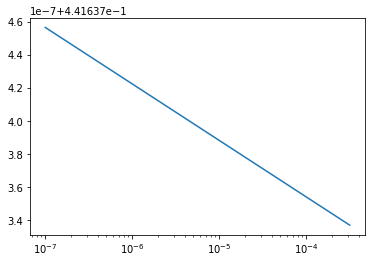

In [5]:
learner = Learner(data_loader_train, data_loader_test, model)
learner.lr_find(model_loss_func, start_lr=1e-7, end_lr=1, num_it=2, num_batch=1)

### 2. fit

#### 2.1 LR Cos Annealing + multi layer LR

---- epoch:0 ------
   [train] Average loss: 38.1702, acc: 33.33%
   [test] Average loss: 0.5860, acc: 100.00%
---- epoch:1 ------
   [train] Average loss: 0.3418, acc: 100.00%
   [test] Average loss: 0.0604, acc: 100.00%
---- epoch:2 ------
   [train] Average loss: 0.0315, acc: 100.00%
   [test] Average loss: 0.0001, acc: 100.00%
---- epoch:3 ------
   [train] Average loss: 0.0001, acc: 100.00%
   [test] Average loss: 0.0000, acc: 100.00%
---- epoch:4 ------
   [train] Average loss: 0.0000, acc: 100.00%
   [test] Average loss: 0.0000, acc: 100.00%
---- epoch:5 ------
   [train] Average loss: 0.0000, acc: 100.00%
   [test] Average loss: 0.0000, acc: 100.00%
---- epoch:6 ------
   [train] Average loss: 0.0000, acc: 100.00%
   [test] Average loss: 0.0000, acc: 100.00%
---- epoch:7 ------
   [train] Average loss: 0.0000, acc: 100.00%
   [test] Average loss: 0.0000, acc: 100.00%
---- epoch:8 ------
   [train] Average loss: 0.0000, acc: 100.00%
   [test] Average loss: 0.0000, acc: 100.00%
-

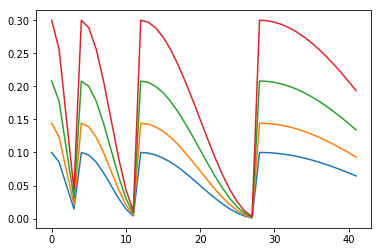

In [6]:
model = nn.Sequential(
    nn.Linear(2, 2), 
    nn.Linear(2, 2),
    nn.Linear(2, 2),
    nn.Linear(2, 2),
)
learner = Learner(data_loader_train, data_loader_test, model)
learner.fit(model_loss_func, [0.1, 0.3], callbacks=LR_TRACKER)

#### 2.2 static LR

---- epoch:0 ------
   [train] Average loss: 0.2930, acc: 100.00%
   [test] Average loss: 0.0000, acc: 100.00%
---- epoch:1 ------
   [train] Average loss: 0.0000, acc: 100.00%
   [test] Average loss: 0.0000, acc: 100.00%


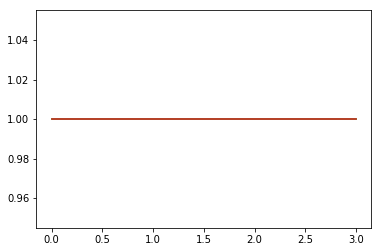

In [7]:
learner.fit(model_loss_func, 1, num_epochs=2, cycle=None, callbacks=LR_TRACKER)

#### 2.3 no callbacks

In [8]:
learner.fit(model_loss_func, 1, num_epochs=2)

---- epoch:0 ------
   [train] Average loss: 0.0000, acc: 100.00%
   [test] Average loss: 0.0000, acc: 100.00%
---- epoch:1 ------
   [train] Average loss: 0.0000, acc: 100.00%
   [test] Average loss: 0.0000, acc: 100.00%


#### 2.4. Predict

In [9]:
learner.predict(model_loss_func)

   [test] Average loss: 0.0000, acc: 100.00%


### 2.5 Skip batch

In [10]:
def model_loss_func(input_data, model, phase):
    input, target = input_data
    output = model(input)
    return output, F.cross_entropy(output, target), True
learner.fit(model_loss_func, 1, num_epochs=2)

---- epoch:0 ------
   [train] Average loss: 0.0000, acc: 100.00%
   [test] Average loss: 0.0000, acc: 100.00%
---- epoch:1 ------
   [train] Average loss: 0.0000, acc: 100.00%
   [test] Average loss: 0.0000, acc: 100.00%


### 3. Custom Loss function / eval_func

---- epoch:0 ------
   [train] Average loss: -15.6992, acc: 0.00%
   [test] Average loss: -123.9834, acc: 0.00%


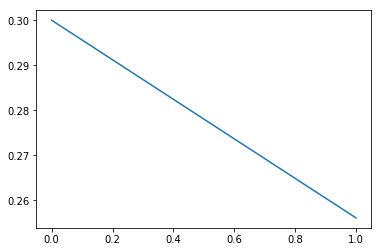

In [11]:
class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.fc = nn.Linear(2, 2)
        
    def forward(self, args):
        return self.fc(args), self.fc(args)
    
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, target):
        sum_output = output1.float() + output2.float()
        return torch.mean(sum_output)

def eval_func(input_data, output, loss):
    input, target = input_data
    output1, output2 = output
    predict = (output1 - output2)
    return predict.eq(target.squeeze().float()).sum().item()

def model_loss_func(input_data, model, phase):
    input, target = input_data
    output1, output2 = model(input)
    return (output1, output2), criterion(output1, output2, target)
    
model = CustomModel()
criterion = ContrastiveLoss()
learner = Learner(data_loader_train, data_loader_test, model)
learner.fit(model_loss_func, [0.1, 0.3], num_epochs=1, callbacks=LR_TRACKER, eval_func=eval_func)